# Exercise 2 - Google Earth Engine for Watershed Data

In this exercise, we will use Google Earth Engine to access long time series of satellite data over extensive areas. This is a nice way to do simple analysis over large areas -- for example, what is the average winter temperature over a watershed? 


## Choosing A Data Source

There are many climate data sets available on Earth Engine, some of which we have seen in the previous exercise. One nice data set that covers many environmental variables is ERA5: [https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5)

ERA5 data provides well-calibrated model outputs from 1940 until the present day -- many of them at hourly resolution! This is a globally consistent data set that is often used to look at temperature, rainfall, and other environmental trends. It also is used to make projections about long-term changes in the environment due to climate change.

There are two main goals for this exercise:

1. Generate time series of environmental parameters (e.g., rainfall sum over a watershed)
2. Generate maps of long-term averages and trends (e.g., average summer temperature over a watershed)

Both of these goals can be accomplished using the same ERA5 data -- we will just be focusing either on a time dimension or the spatial dimension.


To start off, we will load in our required modules again:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import datetime, json
from shapely.geometry import mapping
import geopandas as gpd

In [6]:
import ee
ee.Initialize()
print(ee.__version__)

1.5.1


Let's test again that everything is working as expected:

In [7]:
dem = ee.Image('USGS/SRTMGL1_003') #Load in the global SRTM elevation data set
xy = ee.Geometry.Point([86.9250, 27.9881]) #Define the location of interest
elev = dem.sample(xy, 30).first().get('elevation').getInfo() #Sample the data set at that point
print('Mount Everest elevation (m):', elev) #Print the result

Mount Everest elevation (m): 8729


## Choosing a Study Area

Let's load in a watershed outline. I have chosen an outline that roughly corresponds to the Trishuli. I can open it on [geojson.io](geojson.io): 

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Exercises/Images/Trishuli.png" alt="" style="width: 600px;"/>

You can find the file for download [here](https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/GeoData/Trishuli.geojson). You can also copy and paste that raw data into [geojson.io](geojson.io) to visualize this on a map as above.

You are also welcome to use any geographic data set you like (shapefile, etc) if you already have a watershed outline for your study area. 

We can load that data in with Python:

In [8]:
import geopandas as gpd

trishuli_outline = gpd.read_file('GeoData/Trishuli.geojson')
print(trishuli_outline)

           AREA  PERIMETER  ALL27S_CAT  ALL27S_C_1  \
0  1.168490e+10   618319.0          19          14   

                                            geometry  
0  MULTIPOLYGON (((85.27409 29.00769, 85.27647 29...  


Now we can turn that data into an Earth Engine geometry that we can use for further analysis:

In [9]:
area_of_interest = ee.Geometry.MultiPolygon(ee.List(mapping(trishuli_outline.geometry[0])['coordinates']))
print(area_of_interest.getInfo())

{'type': 'Polygon', 'coordinates': [[[85.27409073943511, 29.007685901722603], [85.27162109251469, 29.00625976688802], [85.2690307331789, 29.00452148536009], [85.26537386937395, 29.002016720482956], [85.2581796263094, 29.002843107385466], [85.25336427003512, 29.00366398675886], [85.25047429461031, 29.002872613681777], [85.25011414576628, 29.000429016342192], [85.25242353609374, 28.99718222257917], [85.25136926187108, 28.993942572412408], [85.24789932587538, 28.990707993838434], [85.24201888100215, 28.989099216543696], [85.2366945677938, 28.989109987236645], [85.23300576684379, 28.99219261258647], [85.22923909769449, 28.99286129483932], [85.225619355501, 28.99480494777039], [85.22285081069607, 28.99643114127902], [85.2145305375565, 28.994825572109846], [85.20899299120333, 28.998077374707176], [85.2062235934864, 28.999469604516168], [85.20622873272964, 29.00192915135276], [85.20069423028784, 29.007006919677725], [85.19791355554884, 29.002959253931266], [85.19231758084541, 29.0006186782150

## Loading in ERA5 Data

Data from ERA5 is available in several formats on Earth Engine. For example:

1. ERA5 Daily: [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY)
2. ERA5 Monthy: [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY)
3. ERA5 Hourly: [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY)

Daily and Monthly data go from 1979-Present (minus 3 months), Hourly data starts at 1950. 

Let's open up the different data sets and compare their sizes:

In [10]:
hourly = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
daily =  ee.ImageCollection("ECMWF/ERA5/DAILY")
monthly =  ee.ImageCollection("ECMWF/ERA5/MONTHLY")
hour_length = hourly.size().getInfo()
daily_length = daily.size().getInfo()
monthly_length = monthly.size().getInfo()
print('Hourly', hour_length)
print('Daily', daily_length)
print('Monthly', monthly_length)

Hourly 658247
Daily 15165
Monthly 498


That is a lot of data! To make things run more quickly, we will focus today on the **monthly** data set. However, if you are interested in using the higher-resolution data, it is easy to simply switch your data source and re-run the same analysis!

## Calculating an Average Time Series

The first goal is to perform a similar analysis as to what we did this morning, except now we will focus over a larger area. Instead of only getting one value from each time (day or month), we will get the average (or minimum, maximum, etc) of all values that are within our watershed.

Thankfully, the calculations are quite similar to what we have done earlier -- it does not take very much more effort to process much more data!

First, let's look at what different data sets we can use: [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY)

I am going to start with **total_precipitation**, but feel free to choose a different variable. The steps will be exactly the same.

In [11]:
def export_time_series_data(collection, geometry, variable):
    def create_time_series(image):
        date = image.get('system:time_start')
        mean = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry).get(variable)
        maximum = image.reduceRegion(reducer=ee.Reducer.max(), geometry=geometry).get(variable)
        minimum = image.reduceRegion(reducer=ee.Reducer.min(), geometry=geometry).get(variable)
        ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'min': minimum, 'mean':mean, 'max':maximum})
        return ft

    time_series = collection.map(create_time_series).getInfo()
    
    dates, means, mins, maxs = [], [], [], []
    for f in time_series['features']:
        properties = f['properties']
        date = properties['date']
        dates.append(datetime.datetime.strptime(date,'%Y/%m/%d')) #Convert the date into something that Python recognizes
        val = properties['mean']
        means.append(val)
        val = properties['min']
        mins.append(val)
        val = properties['max']
        maxs.append(val)
        
    return np.array(dates), np.array(means), np.array(mins), np.array(maxs)

dates, means, mins, maxs = export_time_series_data(monthly, area_of_interest, 'total_precipitation')

Notice that we use several different _reducers_ -- these are basic math functions that are available on Google Earth Engine. They allow us to perform complex operations using a simple line of code. There are quite a few available, see here: [https://developers.google.com/earth-engine/guides/reducers_intro](https://developers.google.com/earth-engine/guides/reducers_intro)

Now that we have the data, we can plot the time series:

Text(0, 0.5, 'Max Monthly Precipitation Sum (m)')

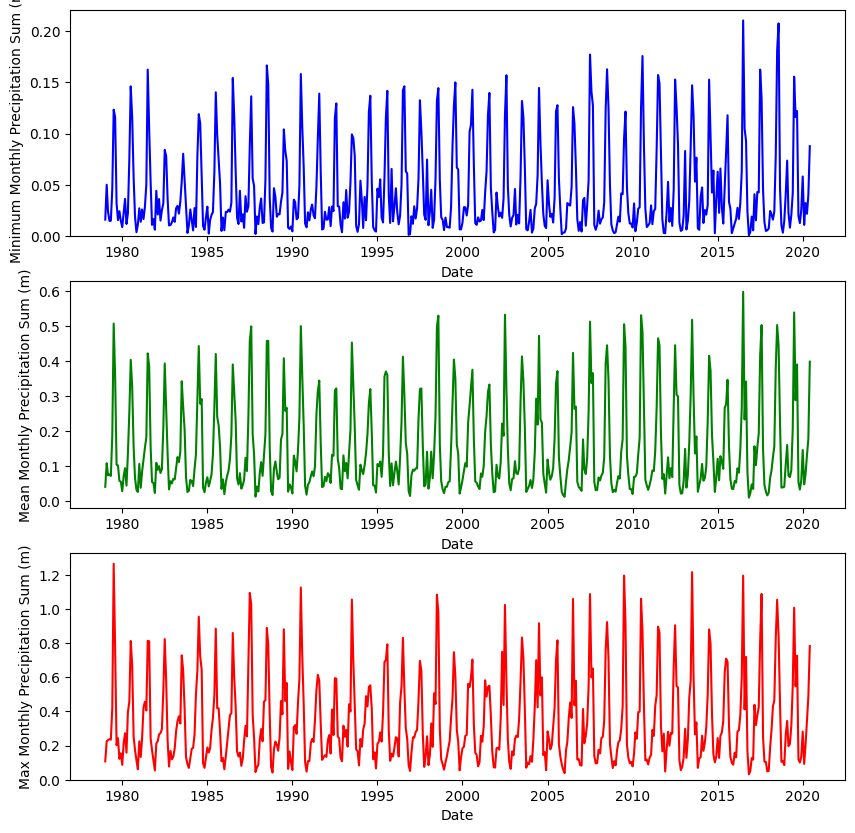

In [12]:
f, (ax, ax2, ax3) = plt.subplots(3, figsize=(10,10))

ax.plot(dates, mins, 'b')
ax.set_ylim(ymin=0)
ax.set_xlabel('Date')
ax.set_ylabel('Minimum Monthly Precipitation Sum (m)')

ax2.plot(dates, means, 'g')
ax.set_ylim(ymin=0)
ax2.set_xlabel('Date')
ax2.set_ylabel('Mean Monthly Precipitation Sum (m)')

ax3.plot(dates, maxs, 'r')
ax3.set_ylim(ymin=0)
ax3.set_xlabel('Date')
ax3.set_ylabel('Max Monthly Precipitation Sum (m)')

This is very similar to what we did in the first exercise, except that we are looking at **a much larger area**. This also took very little time, but provided us a _watershed average_ precipitation data set over a long time period. This is very useful for looking at historical trends, abnormal years, and changes in seasonality of precipitation (or other variables). 

Let's make one more plot that shows how varied precipitation can be within one watershed -- if I simply subtract the minimum from the maximum, I can tell how consistent the monthly rainfall sums are across the watershed. This gives me an idea whether all parts of the watershed will receive similar rainfall, and how widely it can vary.

Text(0, 0.5, 'Range Monthly Precipitation Sum (m)')

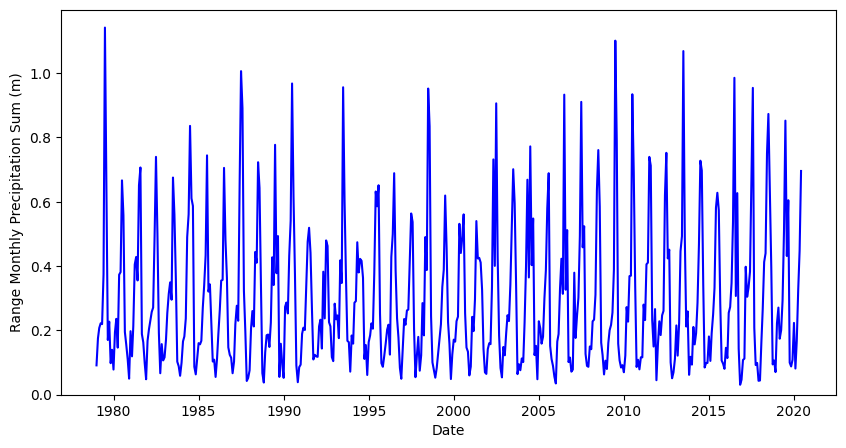

In [13]:
f, ax = plt.subplots(1, figsize=(10,5))

ax.plot(dates, maxs - mins, 'b')
ax.set_ylim(ymin=0)
ax.set_xlabel('Date')
ax.set_ylabel('Range Monthly Precipitation Sum (m)')

That is a really big range! Sometimes there is a difference of more than a meter of precipitation _within the same watershed_. 

While this is useful information for some purposes, it is also really helpful to display this data on a **map**. To do this, we want to create averages (or minimums, or trends) for each point on our map. 

## Creating Long-Term Average Maps

We can use the same **reducer** tools to do operations over _space_ instead of _time_. However, since the data we create are much larger, it is not possible to download them directly -- we can only make simple web-based visualizations. However, we can also export the output of our analysis to Google Drive, where we can use it for further analysis.

Let's first create a simple long-term monthly mean precipitation sum:

In [14]:
lt_mean = monthly.select('total_precipitation').reduce(ee.Reducer.mean())

Yes, that is really the whole command! Since we are not doing any of the processing on our computer, Google Earth Engine takes care of most of the heavy work for us. However, it is not possible to directly download the data like the time series:

In [15]:
data = lt_mean.getInfo()
print(data)

{'type': 'Image', 'bands': [{'id': 'total_precipitation_mean', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


That only gives us _metadata_ about the calculation we have performed. If we want to visualize the data, we can use the _geemap_ Python module.

NOTE: You may need to enable the ipyleaflet extension if the below code does not run:

    jupyter nbextension enable --py --sys-prefix ipyleaflet


In [16]:
import geemap
cenx, ceny = trishuli_outline.centroid[0].x, trishuli_outline.centroid[0].y
Map = geemap.Map(center=[ceny, cenx], zoom=6)
image_viz_params = {'palette': ['00204C', '213D6B', '555B6C', '7B7A77', 'A59C74', 'D3C064', 'FFE945'],'min': 0,'max': 1, 'opacity':0.9}
Map.addLayer(lt_mean, image_viz_params)
Map.addLayer(area_of_interest)

Map

/var/folders/24/5v8vw241227213_kt_ty_g700000gn/T/ipykernel_85644/1146444906.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cenx, ceny = trishuli_outline.centroid[0].x, trishuli_outline.centroid[0].y


Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

This is a nice interactive web map that you can move around in -- you can also click on any point to get a value, change the colors, etc. This can also be exported and added to a website!

Let's try this with the maximum monthly precipitation as well:

In [17]:
lt_max = monthly.select('total_precipitation').reduce(ee.Reducer.max())
Map = geemap.Map(center=[ceny, cenx], zoom=6)
image_viz_params = {'palette': ['00204C', '213D6B', '555B6C', '7B7A77', 'A59C74', 'D3C064', 'FFE945'],'min': 0,'max': 1, 'opacity':0.9}
Map.addLayer(lt_max, image_viz_params)
Map.addLayer(area_of_interest)

Map

Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

It's quite clear to see the pattern of the monsoon in the data -- even if it isn't the highest spatial resolution! 

Let's try one more reducer: linear trend. We need to do one extra step before we use this reducer, which is to add a _time_ band (so we have an x and a y for our linear trend). We can do this with a simple function:

In [18]:
def to_mm(image):
    mm_band = image.select('total_precipitation').multiply(1000).set('system:time_start', image.get('system:time_start'))
    return image.addBands(mm_band.rename('total_precipitation_mm'))

def time_regression(collection, variable, spacing='year'):
    def addtime(image):
        date = image.date()
        years = date.difference(ee.Date('1900-01-01'), spacing)
        return image.addBands(ee.Image(years).rename('t')).float()

    prepped = collection.map(addtime) #Add the new time band
    to_process = prepped.select(['t', variable]) #Choose what variable to regress against time
    
    return to_process.reduce(ee.Reducer.linearFit())

monthly_mm = monthly.map(to_mm)
precip_annual_trend = time_regression(monthly_mm, 'total_precipitation_mm').select('scale')

In [19]:
Map = geemap.Map(center=[ceny, cenx], zoom=6)
image_viz_params = {'palette': ['3B4CC0', '6F91F2', 'A9C5FC', 'DDDDDD', 'F6B69B', 'E6745B', 'B40426'],'min': -1,'max': 1, 'opacity':0.9}
Map.addLayer(precip_annual_trend, image_viz_params)
Map.addLayer(area_of_interest)

Map

Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

We can run the same analysis using _air temperature_ to compare the results:

In [20]:
temp_annual_trend = time_regression(monthly, 'mean_2m_air_temperature').select('scale')

In [21]:
Map = geemap.Map(center=[ceny, cenx], zoom=6)
image_viz_params = {'palette': ['3B4CC0', '6F91F2', 'A9C5FC', 'DDDDDD', 'F6B69B', 'E6745B', 'B40426'],'min': -0.05,'max': 0.05, 'opacity':0.9}
Map.addLayer(temp_annual_trend, image_viz_params)
Map.addLayer(area_of_interest)

Map

Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

This goes really quick! This is a very nice way to quickly analyze large climate data without having to download anything.

If you want to use these images for further analysis or for making your own maps, we can _export_ the data to Google Drive. This can be done with this small function:

In [22]:
def run_export(image, crs, filename, scale, region, maxPixels=1e12, cloud_optimized=True):
    task_config = {'fileNamePrefix': filename,'crs': crs,'scale': scale,'maxPixels': maxPixels, 'fileFormat': 'GeoTIFF', 'formatOptions': {'cloudOptimized': cloud_optimized}, 'region': region,}
    task = ee.batch.Export.image.toDrive(image, filename, **task_config)
    task.start()
    
run_export(temp_annual_trend, 'epsg:4326', 'ERA5_MonthlyMeanTemp_Trend_1979-2023', scale=27830, region=area_of_interest)

Let's also export one over a bigger area for comparison:

In [23]:
minx, maxx, miny, maxy = [65, 110, 25, 45]
regional_extent = ee.Geometry.Polygon([[minx, maxy], [maxx, maxy], [maxx, miny], [minx, miny]])
run_export(temp_annual_trend, 'epsg:4326', 'ERA5_MonthlyMeanTemp_Trend_1979-2023_large', scale=27830, region=regional_extent)

This runs quite quickly: 

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Exercises/Images/EE_Tasks.png" alt="" style="width: 600px;"/>

You can see the progress at [https://code.earthengine.google.com/tasks](https://code.earthengine.google.com/tasks).

We can also now open up the data in QGIS to visualize further:

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Exercises/Images/QGIS_Output.png" alt="" style="width: 600px;"/>

Notice that the size of the data is very small -- if we wanted to download the whole original data set, that would be many of hundreds of GB. Instead, we can perform some simple analysis on the data and only export the results. This is one of the most important parts of Google Earth Engine -- we now have access to a huge library of data, as well as the tools to do powerful analysis without needing our own big computer setup. 

## Bonus Example -- More Complex Analysis

Let's do one more quick exercise which focuses on higher-resolution data. I want to make two maps focusing on the distribution of snow within my watershed. These should cover two topics:

1. Number of Snow Cover Days (on average)
2. Average Winter (December-January-February) Snow Cover Percentage

To do this, I will use MODIS Snow Cover Data (500 m resolution), available here: 

In [24]:
def winter_filter(collection):
    allfilts = []
    for m in [12, 1, 2]:
        allfilts.append(ee.Filter.calendarRange(m, m, 'month'))
    
    filt = ee.Filter.Or(allfilts)    
    return collection.filter(filt)

snow_cover = ee.ImageCollection("MODIS/061/MOD10A1").select('NDSI_Snow_Cover')
djf_snow_cover = winter_filter(snow_cover)

First let's get the average winter snow cover:

In [25]:
avg_snow_cover = djf_snow_cover.reduce(ee.Reducer.mean())

Map = geemap.Map(center=[ceny, cenx], zoom=8)
image_viz_params = {'palette': ['3B4CC0', '6F91F2', 'A9C5FC', 'DDDDDD', 'F6B69B', 'E6745B', 'B40426'],'min': 0,'max': 100, 'opacity':0.9}
Map.addLayer(avg_snow_cover, image_viz_params)
Map.addLayer(area_of_interest)

Map

Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

Now let's count the number of days that are above 5% snow covered:

In [26]:
def mask_(image):
    mask = image.lt(5)
    return image.updateMask(mask)

masked_sca = snow_cover.map(mask_)
count = masked_sca.reduce(ee.Reducer.count())

Map = geemap.Map(center=[ceny, cenx], zoom=8)
image_viz_params = {'palette': ['3B4CC0', '6F91F2', 'A9C5FC', 'DDDDDD', 'F6B69B', 'E6745B', 'B40426'],'min': 100,'max': 5000, 'opacity':0.9}
Map.addLayer(count, image_viz_params)
Map.addLayer(area_of_interest)

Map

Map(center=[28.3482633833965, 85.09248849480274], controls=(WidgetControl(options=['position', 'transparent_bg…

We can also export the data as before -- this will take a little longer, but still not very long for how much data is being used!

In [27]:
avg_snow_cover = djf_snow_cover.reduce(ee.Reducer.mean())
run_export(avg_snow_cover, 'epsg:4326', 'MODIS_WinterSnowCover_2000-2023', scale=500, region=regional_extent)

## Further Information

This was a short introduction to show what the possibilities are with online data processing. There are many data sets available on Google Earth Engine, covering many different environmental parameters. A full list can be found here: [https://developers.google.com/earth-engine/datasets](https://developers.google.com/earth-engine/datasets)

There are also many community data sets hosted here: [https://gee-community-catalog.org/](https://gee-community-catalog.org/) These include soil data, hydrological data, and climate data. Any of these data sets can be used the same way as we did in this example!

There is usually some data set that can be used to answer your question!